In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from skimage.util import random_noise

In [2]:
DIRECTROY = 'data'
MODEL_PATH = 'models'
IMG_SIZE = 224

In [3]:
def resize_img(a):
    w, h = a.size
    if w < h:
        scale = h/IMG_SIZE
        w = int(w/scale)
        h = IMG_SIZE
        a = a.resize((w, h))
        lb= np.array([a.load()[0,x] for x in range(h)])
        rb = np.array([a.load()[w-1,x] for x in range(h)])
        lb = lb.mean(axis=0).astype('uint8')
        rb = rb.mean(axis=0).astype('uint8')
        pic = Image.new('RGB', (h, h), color = (255, 255, 255))
        imgl = Image.new('RGB', (h//2, h), color = tuple(lb))
        imgr = Image.new('RGB', (h//2, h), color = tuple(rb))
        
        pic.paste(imgl, (0, 0))
        pic.paste(imgr, (h//2, 0))
        
        pic.paste(a, (h//2-w//2, 0))

    elif w>h:
        scale = w/IMG_SIZE
        h = int(h/scale)
        w = IMG_SIZE
        a = a.resize((w, h))
        
        lb= np.array([a.load()[x,0] for x in range(w)])
        rb = np.array([a.load()[x,h-1] for x in range(w)])
        lb = lb.mean(axis=0).astype('uint8')
        rb = rb.mean(axis=0).astype('uint8')
        
        pic = Image.new('RGB', (w, w), color = (255, 255, 255))
        imgl = Image.new('RGB', (w, w//2), color = tuple(lb))
        imgr = Image.new('RGB', (w, w//2), color = tuple(rb))
        
        pic.paste(imgl, (0, 0))
        pic.paste(imgr, (0, w//2))
        
        pic.paste(a, (0, w//2-h//2))

    else:
        a = a.resize((IMG_SIZE, IMG_SIZE))
        pic = a
    return pic

### Change image in following methods

- Vertical flip
- Horizontal flip
- Rotate 30 degree
- Zoom
- Random noise
- Random blocks cover the images

In [4]:
df_train = pd.read_csv(f'{DIRECTROY}/reduced_train.csv') 
df_test = pd.read_csv(f'{DIRECTROY}/reduced_test.csv') 

In [3]:
def flip_image_vertical(image):
    return Image.fromarray(np.fliplr(image))

def flip_image_horizontal(image):
    return Image.fromarray(np.flipud(image))

def rotate_image(image, angle=30):
    return image.rotate(angle)


def randomCrop(im, margin=1.25):
    '''
    croping the image in the center from a random margin from the borders
    '''
    mg = int(np.random.rand()*30)
    margin -=1
    margin/=2
    start = [mg + im.size[0]*margin, mg + im.size[0]*margin]
    end = [min(mg+ im.size[0] * (1-margin), im.size[0]),  min(mg+im.size[1]*(1-margin), im.size[1])]
    cropped_image = im.crop((start[0], start[1], end[0], end[1]))
    return cropped_image

def add_noise(image):
    img =  random_noise(np.array(image))*255
    img = Image.fromarray(img.astype('uint8'))
    return img

def add_random_box(img):
    box_width = np.random.randint(20,50)
    color = list(np.random.choice(range(256), size=3))
    img2 = img.copy()
    img2.paste(Image.new('RGB', (box_width, box_width), color = tuple(color)), (np.random.randint(0,IMG_SIZE-box_width), np.random.randint(0,IMG_SIZE-box_width)))
    return img2


In [4]:
def resize_images(df,tasks='train'):
    for x in df['name']:
        img = Image.open(f'{DIRECTROY}/{tasks}/{x}')
        img = resize_img(img)
        img.save(f'{DIRECTROY}/aug_{tasks}/{x}')

In [39]:
resize_images(df_train)

In [17]:
img = Image.open(f'{DIRECTROY}/train/1.jpg')

In [18]:
img = resize_img(img)

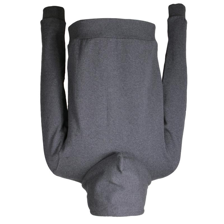

In [19]:
flip_image_horizontal(img)

In [5]:
from tqdm import tqdm

In [6]:
def augment_image(df_train, type='horizontal'):
    df_aug = df_train.sample(frac=0.245)
    images = df_aug['name'].values
    for image in tqdm(images, desc=f'Augmenting {type} images'):
        im = Image.open(f'{DIRECTROY}/train/{image}')
        if type == 'horizontal':
            im = flip_image_horizontal(im)
        elif type == 'vertical':
            im = flip_image_vertical(im)
        elif type == 'rotate':
            im = resize_img(im)
            im = rotate_image(im)
        elif type == 'crop':
            im = resize_img(im)
            im = randomCrop(im)
        elif type == 'noise':
            im = add_noise(im)
        elif type == 'box':
            im = resize_img(im)
            im = add_random_box(im)
        im = resize_img(im)
        im.save(f'{DIRECTROY}/aug_train/{type}_{image}')
    
    df_aug['name'] = df_aug['name'].apply(lambda x: f'{type}_{x}')
    return df_aug

In [24]:
df_h = augment_image(df_train, type='horizontal')
df_v = augment_image(df_train, type='vertical')
df_r = augment_image(df_train, type='rotate')
df_c = augment_image(df_train, type='crop')
df_n = augment_image(df_train, type='noise')
df_b = augment_image(df_train, type='box')

Augmenting horizontal images:   0%|          | 0/7165 [00:00<?, ?it/s]

Augmenting box images: 100%|██████████| 7165/7165 [01:23<00:00, 85.49it/s] 


In [ ]:
for i in range(len(df_train)):
    img = Image.open(f'{DIRECTROY}/train/{df_train.iloc[i].name}')
    img = resize_img(img)
    img.save(f'{DIRECTROY}/resize_train/{df_train.iloc[i].name}')

In [25]:
df_aug = pd.concat([df_train, df_h, df_v, df_r, df_c, df_n,df_b])

In [26]:
len(df_aug)

72233

In [27]:
len(df_train)

29243

In [28]:
df_aug.sample(frac=1).to_csv(f'{DIRECTROY}/augmented_train.csv', index=False)

In [5]:
df_aug = pd.read_csv(f'{DIRECTROY}/augmented_train.csv')

### Create dataloader 
Split dataset to multiple pack due to lack of ram

In [7]:
from transformers import CLIPTokenizerFast
import torch
from torchvision.transforms import Compose, ToTensor, Lambda, Resize, Normalize
from torch.utils.data import Dataset

In [8]:
image_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(), 
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, df, transforms, directory):
        self.tokenizer =  CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch16")
        self.df = df
        self.transforms = transforms
        self.directory = directory
        self.labels = torch.Tensor(df['newid'].values).long()
        self.imgs = torch.cat([ self.transforms(Image.open(f'{DIRECTROY}/{self.directory}/{x}').convert('RGB')).half().reshape(1,3,IMG_SIZE,IMG_SIZE) for x in tqdm(df['name'].values)])
        self.tokenized = self.tokenizer([f'a photo of {x}' for x in df['label'].values], padding=True, truncation=True, return_tensors="pt")
        self.input_ids = self.tokenized['input_ids']
        self.attention_mask = self.tokenized['attention_mask']
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        return img, label, input_ids, attention_mask

In [9]:
import math

In [10]:
for i in range(math.ceil(len(df_aug)/36384)):
    train_dataset = CustomDataset(df_aug[i*36384:(i+1)*36384], image_transforms, 'aug_train')
    torch.save(train_dataset, f'{DIRECTROY}/train_dataset/train_dataset_reduced_aug_{i}.pth')
    del train_dataset

100%|██████████| 35849/35849 [01:44<00:00, 341.93it/s]


In [ ]:
test_dataset = CustomDataset(df_test, image_transforms, 'test')
torch.save(test_dataset, f'{DIRECTROY}/test_public_dataset/test_dataset_reduced_2.pth')